This notebook SNIP is a very brief use case applying how we can use centroids from previous malware analysis to build a classifier of new malware. 
This notebook is built by Solomon Sonya

# imports

In [1]:
print('configuring imports now...')

import threading
import pandas as pd
import time
import random
import os
from sklearn.metrics import *
from sklearn.feature_extraction.text import *
from tabulate import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re
import logging
import inspect
import io
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from pathlib import Path
import csv
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from datetime import *
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import joblib
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.signal import find_peaks
from matplotlib import gridspec
from scipy.stats import mode
from scipy.stats import entropy
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from kneed import KneeLocator

import warnings
warnings.filterwarnings('ignore')

print('imports complete')

configuring imports now...
imports complete


# Load MABEL Dataset SNIP

In [6]:
###############################################################################################################################
# Import DataSet
##############################################################################################################################
input_file_path = 'pe_metadata_master_table_grayscale_dataset_v1_normalized_import_functions.csv'
print(f'reading MABEL snip file MABEL snip--> {input_file_path}')
df_original_input = pd.read_csv(input_file_path, sep=',')
print('read complete!')

###############################################################################################################################
# Set Variables
##############################################################################################################################
class_label_name = 'family_name'
feature_name = 'standardized_import_functions'
feature_name_and_library_name = 'import_functions'
unique_instance_identifier = 'sha256_hash'
sort_feature_name = 'count_import_functions'
ACTIVE_THREAD_COUNT = 1
df_to_analyze = df_original_input


##############################################################################################################################
# Run Single Threaded Tests
##############################################################################################################################
label = class_label_name

# get list of unique labels
lst_unique_labels = list(df_to_analyze[label].unique())

# prepare dictionary of active and completed threads
lst_ready_threads = list()
dict_COMPLETED_threads = dict()
lst_RUNNING_threads = list()
  

###########################################################################################################
# filter df
###########################################################################################################
lst_initial_feature_names = [   'sha256_hash',
                                    'clam_av_scan_results',
                                    'yara_malware',
                                    'family_name',
                                    'sample_name',
                                    'md5_hash',
                                    'sha1_hash',
                                    'sha224_hash',
                                    'sha384_hash',
                                    'sha512_hash',
                                    'ssdeep',
                                    'file_size',
                                    'binary_file_size',
                                    'time_stamp',
                                    'file_type_extension',
                                    'summary_detected_languages',
                                    'entropy(min=0.0; max=8.0)',
                                    'execution_section_name',
                                    'execution_size_bytes',
                                    'import_functions',
                                    'standardized_import_functions',
                                    'count_import_functions',
                                    'peid',
                                    'yara_packer',
                                    'yara_rat',
                                    'code_sections',
                                    'code_section_sizes',
                                    'entropy_per_section',
                                    'number_sections'                                     
                                ]

df_input = df_original_input.filter(items=lst_initial_feature_names)

reading MABEL snip file MABEL snip--> pe_metadata_master_table_grayscale_dataset_v1_normalized_import_functions.csv
read complete!


# <span style="color:blue"> Vectorize all Malware Variant Centroids for Classification </span>

In [7]:
path_MASTER_malware_family_centroids = '_malware_family_variant_centroids.csv'

##########################################################################
# read centroid
##########################################################################
print(f'reading in master centroid file at path --> {path_MASTER_malware_family_centroids}')
df_centroid = pd.read_csv(path_MASTER_malware_family_centroids, sep=',')
print(f'read complete. num rows imported: {len(df_centroid)}')

##########################################################################
# init
##########################################################################
class_label_name = 'family_name'
feature_name = 'standardized_import_functions'
feature_name_and_library_name = 'import_functions'
sort_feature_name = 'count_import_functions'
distance_metric = 'cosine'
instance_identifier_name = 'sha256_hash'

##########################################################################
# vectorize centroid file
##########################################################################
print(f'Vectorizing dataframe now...')
tf_idf_vectorizer = TfidfVectorizer(norm='l2')
mtx_tf_idf = tf_idf_vectorizer.fit_transform(df_centroid[feature_name])

print(f'vectorization complete. Calculating {distance_metric} pairwise distances now...')
# calculate euclidean distance from vectorized input
distance_matrix = pairwise_distances(mtx_tf_idf, metric=distance_metric)  # --> metric='cosine'

# convert mtx to dataframe for processing
df_distance_matrix = pd.DataFrame(distance_matrix, index=df_centroid[instance_identifier_name].tolist(), columns=df_centroid[instance_identifier_name])

# store raw output
df_distance_matrix.to_csv('./df_distance_matrix_centroid.csv', index=True)

########################################################################    
# normalize distances and convert to percentage
########################################################################    

# get the max value for normalization
max_distance = np.max(distance_matrix)

# calculate distance percentages
if distance_metric == 'cosine':
    similarity_matrix = (1 - distance_matrix) # values from vectorizer are already L2 normalized, thus since non-negative values, our cosine similarity is guaranteed to be between 0 and 1
else:
    similarity_matrix = (1 - distance_matrix / max_distance)

# convert matrix to dataframe
df_similarity_matrix = pd.DataFrame(similarity_matrix, index=df_centroid[instance_identifier_name].tolist(), columns=df_centroid[instance_identifier_name])

# store raw output --> INTRODUCE EUCLIDEAN_SIMILARITY
df_similarity_matrix.to_csv('./df_similarity_matrix_centroid.csv', index=True)

print('drawing interactive 3D chart now...')


jitter_value = 0.08
chart_title = f'Malware Family 3D Scatter Plot: PCA of Cosine Similarity Matrix with ({jitter_value}) jitter'                               
# ==> interactive_3d_scatter_plot(df_similarity_matrix, df_input, 'all_samples', 'cosine', './malware_family_centroids.html', jitter_value, False, 0.60, 'sha256_hash', 'intra_family_cosine_similarity_cluster',  -1, chart_title)

print('\n\n\nCOMPLETE!!!!')

reading in master centroid file at path --> _malware_family_variant_centroids.csv
read complete. num rows imported: 23
Vectorizing dataframe now...
vectorization complete. Calculating cosine pairwise distances now...
drawing interactive 3D chart now...



COMPLETE!!!!


# Process the Data

Commencing PCA of cosine similarity matrix into 3D scatter plot. Jitter is set to 0.08. cosine_similarity_cluster_threshold_percentage is set to [0.6]...


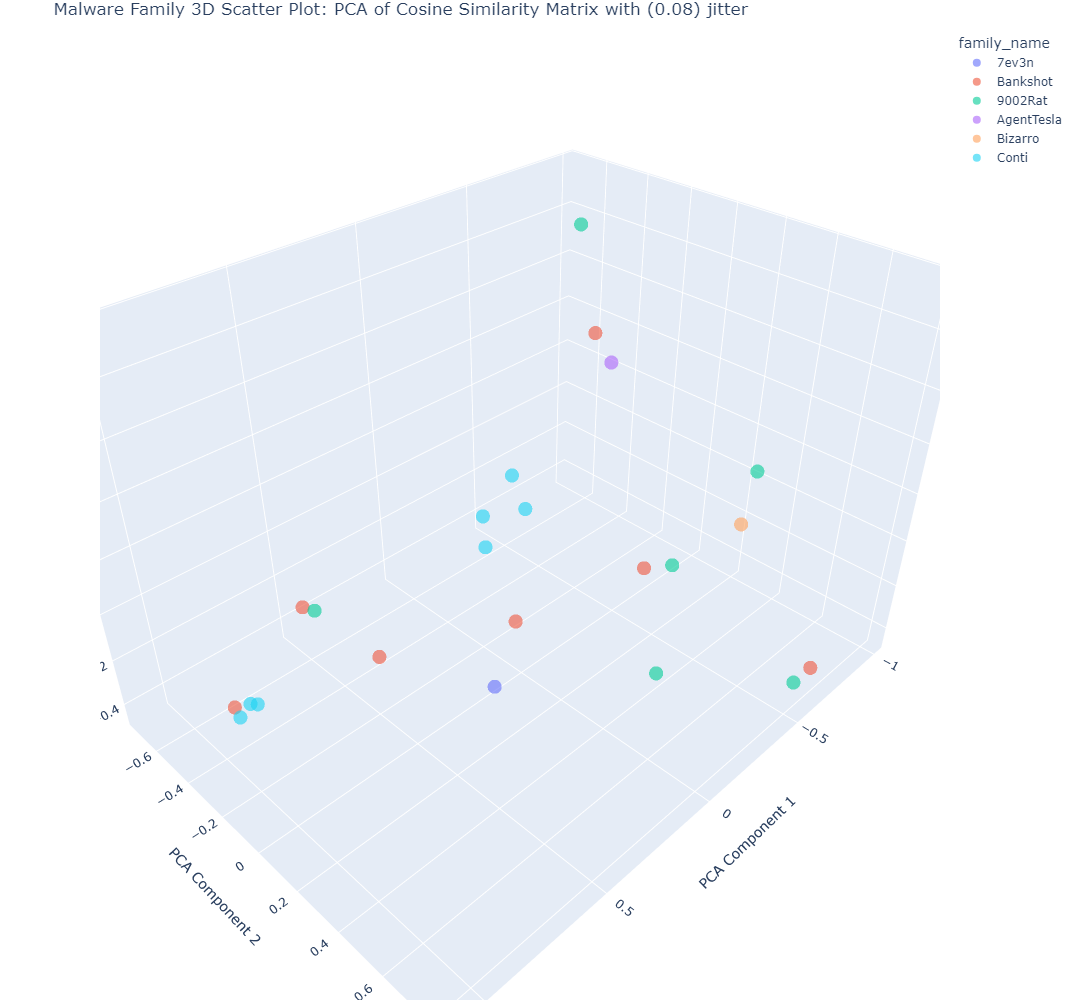

COMPLETE! Interactive 3D scatter plot saved to --> ./malware_family_centroids.html


In [8]:
cosine_similarity_cluster_threshold_percentage = 0.60
optimal_k = -1
instance_identifier = 'sha256_hash'
#df_original_dataset = df_input
cluster_feature_name = 'intra_family_cosine_similarity_cluster'
output_path = './malware_family_centroids.html'
distance_metric = 'cosine'
jitter_value = 0.08
####################################


##################################
# create unique index for each malware family mapping
unique_malware_family = df_centroid['family_name'].unique()
family_name_to_index = {family: idx for idx, family in enumerate(unique_malware_family)}

df_centroid['family_name_index'] = df_centroid['family_name'].map(family_name_to_index)


##################################

#try:
# notify
if cosine_similarity_cluster_threshold_percentage > -1:
    print(f'Commencing PCA of {distance_metric} similarity matrix into 3D scatter plot. Jitter is set to {jitter_value}. cosine_similarity_cluster_threshold_percentage is set to [{cosine_similarity_cluster_threshold_percentage}]...')
else:
    print(f'Commencing PCA of {distance_metric} into 3D scatter plot. Jitter is set to {jitter_value}. optimal_k is set to [{optimal_k}]...')      

if optimal_k > 0:
    chart_title = str(chart_title) + '. Optimal k: [' + str(optimal_k) + ']'

########################################################################
# validate at least 3 instances exist for PCA to 3D
########################################################################
if len(df_similarity_matrix) < 3:
    print(f"PUNT! I can not proceed with PCA for this similarity matrix. I require at least 3 instances to continue. I was provided: [{len(df_similarity_matrix)}]")
    

########################################################################
# Perform PCA to reduce the dimensions to 3D for the scatter plot
########################################################################            
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_similarity_matrix)

# Add jitter to avoid overlap
jitter = jitter_value * np.random.randn(*pca_result.shape)
pca_result_jitter = pca_result + jitter

# Create a DataFrame for the PCA results
df_pca = pd.DataFrame({
    'PCA Component 1': pca_result_jitter[:, 0],
    'PCA Component 2': pca_result_jitter[:, 1],
    'PCA Component 3': pca_result_jitter[:, 2],
    instance_identifier: df_similarity_matrix.index
})            


########################################################################
# merge df features with pca df
########################################################################


# Merge the selected features back into df_pca
df_pca_with_features = df_pca.merge(df_centroid, on=instance_identifier, how='left')


########################################################################
# update label into df
########################################################################
#df_pca_with_features['family_name'] = label

# Directly get the count_import_functions for the new column
#df_pca_with_features['count_imports'] = df_selected_features['count_import_functions']


########################################################################
# Create a 3D scatter plot using Plotly
########################################################################
fig = px.scatter_3d(
    df_pca_with_features, 
    x='PCA Component 1', 
    y='PCA Component 2', 
    z='PCA Component 3',     
    color='family_name',    
    opacity=0.6,     
    hover_data={'sha256_hash': True, 
                'family_name': True,
                'count_import_functions': True,
                'clam_av_scan_results': True, 
                'yara_malware': True,
                'file_size': True,
                'entropy(min=0.0; max=8.0)': True,
                'malware_variant_centroid': True,                
                #'time_stamp': True, 
                'PCA Component 1': False, 
                'PCA Component 2': False, 
                'PCA Component 3': False, 
                'family_name_index': False}
)

# Optional: Tight layout
fig.update_layout(title=chart_title,
                  margin=dict(l=100, r=0, b=0, t=30), 
                  width=1400,  # Adjust width
                  height=1000   # Adjust height
                 )

########################################################################
# save the plot
########################################################################
fig.write_html(output_path)
fig.show()
print(f"COMPLETE! Interactive 3D scatter plot saved to --> {output_path}")

# <span style="color:purple">  Classify an Instance! </span>

In [9]:
# Instance identifier for classification
instance_indentifier_to_classify = '4ccc43857ccae3151a66d645dd90c36275b32eddf7fa0857da9a7a53ac4481d7'

# Get the instance to classify
instance_to_classify = df_input[df_input['sha256_hash'] == instance_indentifier_to_classify]

# Vectorize the instance using the same vectorizer used on the classification dataset
sparse_mtx_instance_to_classify = tf_idf_vectorizer.transform(instance_to_classify[feature_name])

# Calculate cosine distances between the new instance and all centroids
distance_to_centroids = pairwise_distances(sparse_mtx_instance_to_classify, mtx_tf_idf, metric=distance_metric)

# Convert distances to a DataFrame for easier handling
df_distances_instance_to_centroid = pd.DataFrame(distance_to_centroids, index=[instance_indentifier_to_classify],  
                                                 columns=df_centroid[instance_identifier_name])

# Find the closest centroid by finding the index of the minimum distance
closest_centroid_idx = df_distances_instance_to_centroid.iloc[0].idxmin()

# Get the closest centroid's details (including family name)
df_closest_centroid = df_centroid[df_centroid[instance_identifier_name] == closest_centroid_idx]

# Output the family name of the closest centroid
predicted_family = df_closest_centroid[class_label_name].values[0]
predicted_malware_family_variant = df_closest_centroid["malware_variant"].values[0]

# Notify
print(f'Predicted malware family class for instance: [{instance_indentifier_to_classify}] ==> {predicted_family} - Malware Family Variant: {predicted_malware_family_variant}')

########################################################################    
# Normalize distances to percentage
########################################################################    

# Get the max value for normalization
max_distance = np.max(distance_to_centroids)

# Avoid division by zero (in case max distance is 0)
if max_distance == 0:
    max_distance = 1

# Calculate similarity matrix based on distance metric
if distance_metric == 'cosine':
    # Cosine similarity is 1 - cosine distance (values range between 0 and 1)
    similarity_matrix = 1 - distance_to_centroids
else:
    # Normalize other distances by dividing by max distance (values range between 0 and 1)
    similarity_matrix = 1 - (distance_to_centroids / max_distance)

# Convert similarity matrix to percentage
#similarity_percentage_matrix = similarity_matrix * 100

# Convert matrix to DataFrame for easier handling (use the instance identifier as the row index)
df_similarity_matrix = pd.DataFrame(similarity_matrix, index=[instance_indentifier_to_classify], columns=df_centroid[instance_identifier_name])

# Display the similarity percentage matrix
#df_similarity_matrix


Predicted malware family class for instance: [4ccc43857ccae3151a66d645dd90c36275b32eddf7fa0857da9a7a53ac4481d7] ==> 9002Rat - Malware Family Variant: 9002Rat.6


### View Distance Matrix (this is argmin, i.e., the smallest distance is the centroid of greatest similarity)

In [11]:
df_distances_instance_to_centroid

sha256_hash,66e1592e69420d6046dfc44ac8d9c45e9f563fb533cdc13d9565ae6a5438ef51,051c85e9afe69007f927e1d480449faf87e9b8e65f77dd628aa7bff72d3b1f50,00e02c85d1f05aba51d991979c8a3e1d3236dc4a3ce0022d209f1aef80eaa188,032ccd6ae0a6e49ac93b7bd10c7d249f853fff3f5771a1fe3797f733f09db5a0,022f393cce30d4b234fa924569c11c7b19004819bdaebb119dc9c8a219626244,01d30c80a5abcd5f520ea2b455c165e1606e5126304d7c607217ee1f0aa4407c,0385b2cb41b302115f307a23a9b860dd709554414b1ae108bbf306f899815b17,0c06e129902925c7ebd70e93d4d09707add781d8bd89cd557cda023045f3853e,06fb64ebe50ee96901a339a7c5f686ead86e2ed6b26a7348595839deb611aa96,6cd8eddf21aacaccddffd9949b60201e086ccac434f7074db97fe538f03b600b,...,0414ffdf9dcf32061cc57d0b54bf4410c1c588258c12615988e3ce8cb0cf4fb4,031ebdaf0189694eec6b83ad26e8252547d843780563f54ec06a170f1c0e40d3,07e1ed9c60ef84688cb35923166762cff3325e058dff59a65549efcd22297436,004ede55a972e10d9a21bcf338b4907d6eed65bf5ad6abbbd5aec7d8484bdedf,0460cfa76fb0a02be92b0bc99a09168ebe38dbc8eeb1aa966dca66f0e849b53d,3ab3c4ffcf366dcbe660506295dcef82d058cb25b1c0b362cc62371a19a0d5f8,60c16e45c5cbe88a38911f1e3176d90444e4884261d8481d4d719acec1bc5025,0b0b902af452e1c949a609a3b29a9de21dac639846c77427de06e6e63c1fe904,0fd062f86151b9d49d65b8f12c52737600bff8bb3462aba7bf23d820bf4d5518,16cc7519945bace49ef729e69db7d19e00252f2bd559903e1631c8878c2360f4
4ccc43857ccae3151a66d645dd90c36275b32eddf7fa0857da9a7a53ac4481d7,0.929818,0.951616,0.876721,0.649591,0.928055,0.927367,0.977322,0.887688,0.976994,0.645574,...,0.896512,1.0,0.968108,0.864225,0.895022,0.960151,0.896431,0.944677,1.0,0.864227


### View Similarities Matrix (this is argmax, i.e., the greatest percentage is the centroid of greatest similarity)

In [12]:
df_similarity_matrix

sha256_hash,66e1592e69420d6046dfc44ac8d9c45e9f563fb533cdc13d9565ae6a5438ef51,051c85e9afe69007f927e1d480449faf87e9b8e65f77dd628aa7bff72d3b1f50,00e02c85d1f05aba51d991979c8a3e1d3236dc4a3ce0022d209f1aef80eaa188,032ccd6ae0a6e49ac93b7bd10c7d249f853fff3f5771a1fe3797f733f09db5a0,022f393cce30d4b234fa924569c11c7b19004819bdaebb119dc9c8a219626244,01d30c80a5abcd5f520ea2b455c165e1606e5126304d7c607217ee1f0aa4407c,0385b2cb41b302115f307a23a9b860dd709554414b1ae108bbf306f899815b17,0c06e129902925c7ebd70e93d4d09707add781d8bd89cd557cda023045f3853e,06fb64ebe50ee96901a339a7c5f686ead86e2ed6b26a7348595839deb611aa96,6cd8eddf21aacaccddffd9949b60201e086ccac434f7074db97fe538f03b600b,...,0414ffdf9dcf32061cc57d0b54bf4410c1c588258c12615988e3ce8cb0cf4fb4,031ebdaf0189694eec6b83ad26e8252547d843780563f54ec06a170f1c0e40d3,07e1ed9c60ef84688cb35923166762cff3325e058dff59a65549efcd22297436,004ede55a972e10d9a21bcf338b4907d6eed65bf5ad6abbbd5aec7d8484bdedf,0460cfa76fb0a02be92b0bc99a09168ebe38dbc8eeb1aa966dca66f0e849b53d,3ab3c4ffcf366dcbe660506295dcef82d058cb25b1c0b362cc62371a19a0d5f8,60c16e45c5cbe88a38911f1e3176d90444e4884261d8481d4d719acec1bc5025,0b0b902af452e1c949a609a3b29a9de21dac639846c77427de06e6e63c1fe904,0fd062f86151b9d49d65b8f12c52737600bff8bb3462aba7bf23d820bf4d5518,16cc7519945bace49ef729e69db7d19e00252f2bd559903e1631c8878c2360f4
4ccc43857ccae3151a66d645dd90c36275b32eddf7fa0857da9a7a53ac4481d7,0.070182,0.048384,0.123279,0.350409,0.071945,0.072633,0.022678,0.112312,0.023006,0.354426,...,0.103488,0.0,0.031892,0.135775,0.104978,0.039849,0.103569,0.055323,0.0,0.135773
